# Proyek Pertama : Membuat Model NLP dengan TensorFlow

**NLP untuk analisis sentimen covid**


**Cecep Roni**

sumber dataset : https://www.kaggle.com/datatattle/covid-19-nlp-text-classification/download

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [9]:
# load dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dicoding_PengembanganML/Submission/Coronatweets/Corona_NLP2.csv', encoding = 'ISO-8859-1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [11]:
df.shape

(41157, 6)

In [12]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [14]:
# Hapus Kolom tak terpakai
df2 = df.drop(df.columns[[0,1,2,3]],axis=1)
df2

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


In [15]:
df2.rename(columns={'OriginalTweet': 'tweet', 'Sentiment' : 'sentiment'}, inplace=True)
df2

,tweet,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


## Library and Package

In [16]:
# import library
import nltk, os, re, string

from keras.layers import Input, LSTM, Bidirectional, Dropout, SpatialDropout1D, Dense, Embedding, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
# from keras.utils import to_categorical

from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

In [17]:
#download package
nltk.download('wordnet')
nltk.download('stopwords') 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Cleansing Data

In [18]:
def cleansing(data):
    #Lower Text
    data = data.lower()
    
    #hapus url
    data = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',data)
    pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    pattern1 = re.compile(r'pic.twitter.com/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    data = re.sub(pattern,' ',data) #remove urls if any
    data = re.sub(pattern1,' ',data)
    
    #Hapus Mention
    data = re.sub('@[^\s]+','',data)
    
    # hapus angka
    data = re.sub(r"\d+", "",data)
    
    # hapus covid
    data = re.sub(r"covid", "",data)
    
    #Hapus Hastag
    data = re.sub('#[^\s]+','',data)
    data = re.sub("b' ", "",data)
    data = re.sub("b'","",data)
    data = re.sub('b"','',data)

    #Remove additional white spaces
    data = re.sub('[\n]','',data)
    
    #Remove not alphanumeric symbols white spaces
    data = re.sub(r'[^\w]+', ' ', data)
    
    #Remove :( or :)
    data = data.replace(':)','')
    data = data.replace(':(','')
    
    #trim
    data = data.strip('\'"')
    
    return data

In [19]:
tweet_cleansing = []
for index, row in df2.iterrows():
    tweet_cleansing.append(cleansing(row["tweet"]))

df2['tweet'] = tweet_cleansing
df2.head()

,tweet,sentiment
0,and and,Neutral
1,advice talk to your neighbours family to excha...,Positive
2,coronavirus australia woolworths to give elder...,Positive
3,my food stock is not the only one which is emp...,Positive
4,me ready to go at supermarket during the outbr...,Extremely Negative


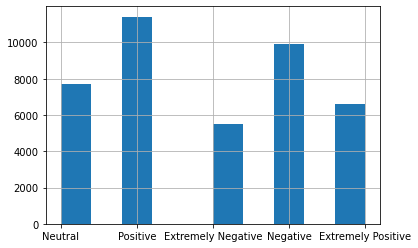

In [20]:
df2.sentiment.hist()

In [21]:
df2.sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: sentiment, dtype: int64

In [22]:
# menyamaratakan jumlah kolom sentimen dengan mengambil jumlah yang terkecil
s_1 = df2[df2['sentiment']=='Extremely Negative'].sample(5481,replace=True)
s_2 = df2[df2['sentiment']=='Extremely Positive'].sample(5481,replace=True)
s_3 = df2[df2['sentiment']=='Negative'].sample(5481,replace=True)
s_4 = df2[df2['sentiment']=='Neutral'].sample(5481,replace=True)
s_5 = df2[df2['sentiment']=='Positive'].sample(5481,replace=True)
df3 = pd.concat([s_1, s_2, s_3, s_4, s_5])

print(df3.shape)
print(df3['sentiment'].value_counts(normalize=True))

(27405, 2)
Negative              0.2
Positive              0.2
Extremely Positive    0.2
Extremely Negative    0.2
Neutral               0.2
Name: sentiment, dtype: float64


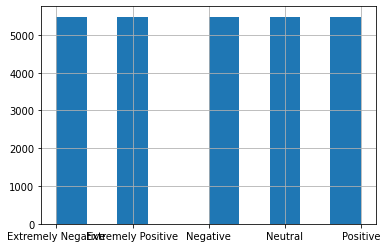

In [23]:
df3.sentiment.hist()

## Model dan Plot

In [24]:
# data sentiment one-hot-encoding

sentiment = pd.get_dummies(df3.sentiment)
df_sentiment = pd.concat([df3, sentiment], axis=1)
df_sentiment = df_sentiment.drop(columns='sentiment')

df_sentiment.rename(columns={'Extremely Negative': 'extrm_negative', 'Extremely Positive' : 'extrm_positive', 'Negative' : 'negative',
                             'Neutral' : 'neutral', 'Positive' : 'positive'}, inplace=True)
df_sentiment.head()

,tweet,extrm_negative,extrm_positive,negative,neutral,positive
16689,good on this store in this should be done ever...,1,0,0,0,0
31698,the collective response to the pandemic from p...,1,0,0,0,0
25290,march the other emergency is crashing the and...,1,0,0,0,0
27252,it s only been a week but tough start for ever...,1,0,0,0,0
38893,there s a lot of stories of councils looking t...,1,0,0,0,0


In [25]:
# ubah dataframe value ke numpy array
tweets = df_sentiment['tweet'].values
label = df_sentiment[['extrm_negative', 'extrm_positive', 'negative', 'neutral', 'positive']].values

In [26]:
# tampilkan tweets dalam array
tweets

array(['good on this store in this should be done everywhere amp businesses that don t comply should be fined assholes always ruin things for everyone ',
       'the collective response to the pandemic from panic buying at grocery stores to restaurant closures is bound to inflate the amount of food waste food loss experts say at a time when food insecurity is on the rise',
       ' march the other emergency is crashing the and other factors have the world teetering on economic depression say experts the tyee ',
       ...,
       'as the pandemic continues to spread worldwide there s a growing concern about the supply and demand of food in the united states speaks with ceo a bobo',
       'pm â donâ t think fresh air provides immunity you have to be m apart take this advice follow it it is crucialâ â of course we will bring forward further measures if necessaryâ ',
       'back home from supermarket well that was an experience now i think i might put myself in a cardboard box with some

In [27]:
# tampilakn kolom sentimen dalam array
label

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [28]:
# split data ke train dan validation

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(tweets, label, test_size=0.2, shuffle=True) 

In [29]:
#tokenisasi
#Import library

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
# Mulai Tokenisasi

tokenisasi = Tokenizer(num_words=5000, oov_token='x', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')
tokenisasi.fit_on_texts(X_train) 
tokenisasi.fit_on_texts(X_val)
 
seq_train = tokenisasi.texts_to_sequences(X_train)
seq_test = tokenisasi.texts_to_sequences(X_val)
 
pad_train = pad_sequences(seq_train) 
pad_test = pad_sequences(seq_test)

In [31]:
# model
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 435,973
Trainable params: 435,973
Non-trainable params: 0
_________________________________________________________________


In [32]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 90%!")
callbacks = myCallback()

In [33]:
# model fit
hist = model.fit(pad_train, y_train, epochs=50, 
                    validation_data=(pad_test, y_val), verbose=2, callbacks=[callbacks], validation_steps=30)

Epoch 1/50
686/686 - 52s - loss: 1.1640 - accuracy: 0.5098 - val_loss: 0.7952 - val_accuracy: 0.7022
Epoch 2/50
686/686 - 49s - loss: 0.6625 - accuracy: 0.7634 - val_loss: 0.6532 - val_accuracy: 0.7643
Epoch 3/50
686/686 - 49s - loss: 0.5019 - accuracy: 0.8333 - val_loss: 0.6352 - val_accuracy: 0.7896
Epoch 4/50
686/686 - 49s - loss: 0.4052 - accuracy: 0.8653 - val_loss: 0.5896 - val_accuracy: 0.8030
Epoch 5/50
686/686 - 49s - loss: 0.3194 - accuracy: 0.8937 - val_loss: 0.5864 - val_accuracy: 0.8161
Epoch 6/50
686/686 - 49s - loss: 0.2532 - accuracy: 0.9167 - val_loss: 0.6482 - val_accuracy: 0.8103
Epoch 7/50
686/686 - 49s - loss: 0.2037 - accuracy: 0.9333 - val_loss: 0.7127 - val_accuracy: 0.8163
Epoch 8/50
686/686 - 49s - loss: 0.1730 - accuracy: 0.9446 - val_loss: 0.7018 - val_accuracy: 0.8174
Epoch 9/50
686/686 - 49s - loss: 0.1393 - accuracy: 0.9554 - val_loss: 0.7938 - val_accuracy: 0.8280
Epoch 10/50
686/686 - 49s - loss: 0.1124 - accuracy: 0.9622 - val_loss: 0.8423 - val_accura

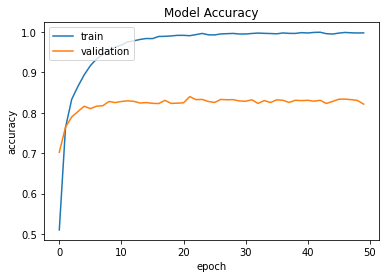

In [35]:
# plot akurasi

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

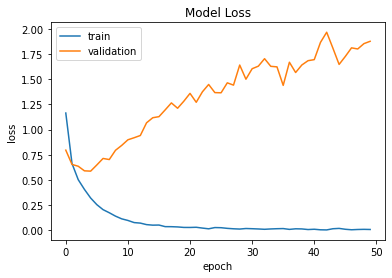

In [36]:
# plot loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()